## Load packages

In [13]:
import os, sys, glob, scipy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tqdm

## Learning Model

The learning model used to generate choices is a simple Rescorla-Wagner (Rescorla & Wagner, 1972) model.

$$ Q(action, trial) = Q(action, trial - 1) + \alpha*prediction_{error}$$
$$ prediction_{error} = r(trial-1) - Q(action, trial - 1)$$
$$ 0 <= \alpha <= 1 $$

In the previous scripts, you have already read about the RL model and also already came across the softmax choice rule (recall the orange juice/coffee example). Now, we are going to use the softmax function again to generate choice probabilities.

### Softmax

In [14]:
def softmax(q_values, beta):
    # Inputs:
    #       q_values: value of different actions, often just 2
    #       beta: inverse temperature, also known as exploitation parameter
    # Outputs:
    #       choice_probs: model's predicted probability of actions

    # Numerator represents value of utility of single choice
    numerator = np.exp(np.multiply(q_values, beta))

    # Denominator represents sum of total value of utilities
    denominator = np.sum(np.exp(np.multiply(q_values, beta)))
    
    # Outputs
    choice_probs = numerator / denominator
        
    return choice_probs


## Simulation

The function task_parameters generates the experimental data that an agent will receive. It defines the volatility of the switching, the block number, the trial number, the probability that the left and right levers give rewards, and whether they actually would give a reward (random sample drawn from that probability).

In [15]:
def task_parameters(volatility = 'low'): 
    
    # Generate dataframe to store simulated results
    sim_exp = pd.DataFrame(columns = ['volatility', 'block', 'block_trial', 'exp_trial', 
                                       'prob_reward_left', 'prob_reward_right', 'reward_left', 'reward_right'])
    
    # Trial sequence
    block_seq = [[17, 15, 19, 18, 15, 17, 19, 15], # high volatility
                [35, 30, 35, 35]] # low volatility
    reward_probs_left = [.7, .3] 
    reward_probs_right = [.3, .7] 

    if volatility == 'low':
        task_blocks = block_seq[1]
        block_prob_reward_left = np.array(reward_probs_left*(np.int(len(task_blocks)/2)))
        block_prob_reward_right = np.array(reward_probs_right*(np.int(len(task_blocks)/2)))
    else: 
        task_blocks = block_seq[0]
        block_prob_reward_left = np.array(reward_probs_left*(np.int(len(task_blocks)/2)))
        block_prob_reward_right = np.array(reward_probs_right*(np.int(len(task_blocks)/2)))

    # generate trials
    trial = 0
    for block in range(len(task_blocks)): 
        block_trial = 0
        # Loop through trials of the block
        for block_trial in range(task_blocks[block]):
            trial += 1
            block_trial += 1
            
            # Generate reward for both choices
            prob_reward_left = block_prob_reward_left[block] # pulls correct probability for left
            prob_reward_right = block_prob_reward_right[block] # pulls correct probability for right
            
            # Left choice
            if np.random.rand() <= prob_reward_left:
                reward_left = 1
            else: 
                reward_left = 0
                
            # Right choice
            if np.random.rand() <= prob_reward_right:
                reward_right = 1
            else: 
                reward_right = 0
                
            # Store results
            trial_data = pd.DataFrame([[volatility, block+1, block_trial, trial, 
                                        prob_reward_left, prob_reward_right, reward_left, reward_right]], 
                                     columns = ['volatility', 'block', 'block_trial', 'exp_trial', 
                                       'prob_reward_left', 'prob_reward_right', 'reward_left', 'reward_right'])
            sim_exp = sim_exp.append(trial_data).reset_index(drop=True)
            
    return sim_exp


### Reinforcement Learning

With the simulated task parameters from the task_parameter function, you can now generate choices with rl_simulate. 

In [16]:
def rl_simulate(params, sim_exp): 
    data = sim_exp.copy()
    # Initialize parameters
    # two alphas? (positive vs negative pes), stickiness? (likelihood of just repeating past action)
    # two-step modeling
    alpha = params[0] # learning param
    beta = params[1] # exploitation param
    q_values = [.5, .5] # q-values for left and right choices start at .5
    
    # Loop over rows in data
    for index, row in data.iterrows(): # loop over rows, slow but easy to understand and index
        
        # Compute probability of chosing left or right
        choice_probs = softmax(q_values, beta) 
        
        # Make choice weighted by probabilities
        # probabilities given by left, right
        if np.random.rand() <= choice_probs[0]:
            choice = 'left'
            choice_num = 0
        else:
            choice = 'right'
            choice_num = 1

                    
        # Store (keep above update)      
        data.at[index, 'choice'] = choice # useful way to append single values
        data.at[index, 'choice_num'] = choice_num
        data.at[index, 'prob_left'] = choice_probs[0]
        data.at[index, 'prob_right'] = choice_probs[1]
        data.at[index, 'q_left'] = q_values[0]
        data.at[index, 'q_right'] = q_values[1]
        
        # Update q_values (to be used on next trial)
        # All the magic happens here
        if choice == 'left':
            pe = row['reward_left'] - q_values[choice_num] # compute pe = reward - q_value['choice']
            q_values[choice_num] = q_values[choice_num] + alpha*pe # update value
        else:
            pe = row['reward_right'] - q_values[choice_num] # compute pe
            q_values[choice_num] = q_values[choice_num] + alpha*pe # update value
                
    # Add final information
    data['alpha'] = alpha
    data['beta'] = beta
    
    return data

##### Exercise 1
Now you have a function to simulate task parameters and a function to simulate choice. Using these two functions, visualize the probability of getting a reward for choosing the right lever and the simulated choice. 
You can also add a running average to visualize how the simulated subject behaved on average. 

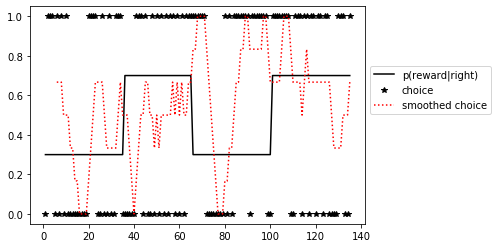

In [18]:
# Simulate task parameters
sim_exp = task_parameters(volatility = 'low')
# Generate data with rl_simulate based on the true parameters and the simulated task parameters
sim_data = rl_simulate(params_true, sim_exp)

# Moving average of 6 trials
sim_data['choice_smoothed'] = sim_data['choice_num'].rolling(window = 6).mean()

# Plot
plt.plot('exp_trial', 'prob_reward_right', 'k', data = sim_data) # black solid line
plt.plot('exp_trial', 'choice_num', 'k*', data = sim_data) # black stars
plt.plot('exp_trial', 'choice_smoothed', 'r:', data = sim_data) # dashed red
plt.legend(['p(reward|right)', 'choice', 'smoothed choice'], bbox_to_anchor = (1, .75))
plt.show()

# Fit simulated data

##### Exercise 2

Adjust rl_simulate to rl_simulate_fit. The rl_simulate_fit function returns the negative loglikelihood based on the alpha and beta parameters and some input data.

In [20]:
def rl_simulate_fit(params, data): 
    
    # Initialize parameters
    # two alphas? (positive vs negative pes), stickiness? (likelihood of just repeating past action)
    # two-step modeling
    alpha = params[0] # learning param
    beta = params[1] # exploitation param
    q_values = [.5, .5] # q-values for left and right choices start at .5
    log_likelihood = 0.
    
    # Loop over rows in data
    for index, row in data.iterrows(): # loop over rows, slow but easy to understand and index
        
        # Compute probability of chosing left or right
        choice_probs = softmax(q_values, beta)
        
        # Determine the choice
        choice = np.int(row['choice_num'])
        
        # Determine reward based on choice
        rewards = [np.int(row['reward_left']), np.int(row['reward_right'])]
        reward = rewards[choice]
        
        # Update likelihood
        log_likelihood += np.log(choice_probs[choice]) # index based on choice 

        pe = reward - q_values[choice] # compute pe = reward - q_value['choice']
        q_values[choice] = q_values[choice] + alpha*pe # update value
                 
    return -log_likelihood

## Parameter fitting

##### Exercise 3

1. simulate task parameters
2. simulate data
3. using the function you defined in exercise 2, fit the model to the simulated data to obtain the best parameters
4. Repeat the model fitting 20 times and store results in fit_results

In [21]:
# define the true alpha and beta
params_true = [0.5, 0.5] 

# Simulate task parameters
sim_exp = task_parameters(volatility = 'low')
# Generate data with rl_simulate based on the true parameters and the simulated task parameters
sim_data = rl_simulate(params_true, sim_exp)

# Objective function for rl_simulate_fit
objective_function = lambda params: rl_simulate_fit(params, sim_data)

# initialize number of iterations 
n_iter = 20

# Create a fit_results dataframe storing the iteration, best parameters and 
# the best negative loglikelihood 
fit_results = pd.DataFrame()

# Loop over the iteration and call on rl_simulate_fit with random alpha and
# beta parameters each time to determine the parameter values with the best fit
for j in tqdm.tqdm(range(n_iter)):
    x0 = np.random.rand(2) # random alpha and beta params
    out = scipy.optimize.fmin(objective_function, x0, full_output=True)
    best_params, best_NLL = out[:2]
    fit_results = fit_results.append(pd.DataFrame([[j, best_params, best_NLL]],
                                             columns = ['iteration','best_params','best_NLL']))

        

  5%|██▏                                        | 1/20 [00:01<00:36,  1.90s/it]

Optimization terminated successfully.
         Current function value: 92.560974
         Iterations: 36
         Function evaluations: 69


 10%|████▎                                      | 2/20 [00:03<00:34,  1.93s/it]

Optimization terminated successfully.
         Current function value: 92.560974
         Iterations: 38
         Function evaluations: 74


 15%|██████▍                                    | 3/20 [00:05<00:32,  1.91s/it]

Optimization terminated successfully.
         Current function value: 92.560974
         Iterations: 31
         Function evaluations: 60


 20%|████████▌                                  | 4/20 [00:08<00:34,  2.17s/it]

Optimization terminated successfully.
         Current function value: 92.560974
         Iterations: 58
         Function evaluations: 104


 25%|██████████▊                                | 5/20 [00:10<00:31,  2.12s/it]

Optimization terminated successfully.
         Current function value: 92.560974
         Iterations: 38
         Function evaluations: 74


 30%|████████████▉                              | 6/20 [00:12<00:27,  1.98s/it]

Optimization terminated successfully.
         Current function value: 92.560974
         Iterations: 27
         Function evaluations: 53


 35%|███████████████                            | 7/20 [00:14<00:27,  2.11s/it]

Optimization terminated successfully.
         Current function value: 92.560974
         Iterations: 47
         Function evaluations: 88


 40%|█████████████████▏                         | 8/20 [00:16<00:23,  1.96s/it]

Optimization terminated successfully.
         Current function value: 92.560974
         Iterations: 30
         Function evaluations: 58


 45%|███████████████████▎                       | 9/20 [00:18<00:21,  1.98s/it]

Optimization terminated successfully.
         Current function value: 92.560974
         Iterations: 41
         Function evaluations: 79


 50%|█████████████████████                     | 10/20 [00:19<00:18,  1.82s/it]

Optimization terminated successfully.
         Current function value: 92.560974
         Iterations: 32
         Function evaluations: 60


 55%|███████████████████████                   | 11/20 [00:21<00:16,  1.86s/it]

Optimization terminated successfully.
         Current function value: 92.560974
         Iterations: 43
         Function evaluations: 81


 60%|█████████████████████████▏                | 12/20 [00:23<00:14,  1.82s/it]

Optimization terminated successfully.
         Current function value: 92.560974
         Iterations: 41
         Function evaluations: 76


 65%|███████████████████████████▎              | 13/20 [00:25<00:12,  1.77s/it]

Optimization terminated successfully.
         Current function value: 92.560974
         Iterations: 38
         Function evaluations: 73


 70%|█████████████████████████████▍            | 14/20 [00:26<00:09,  1.64s/it]

Optimization terminated successfully.
         Current function value: 92.560974
         Iterations: 33
         Function evaluations: 61


 75%|███████████████████████████████▌          | 15/20 [00:27<00:08,  1.63s/it]

Optimization terminated successfully.
         Current function value: 92.560974
         Iterations: 37
         Function evaluations: 73


 80%|█████████████████████████████████▌        | 16/20 [00:29<00:06,  1.65s/it]

Optimization terminated successfully.
         Current function value: 92.560974
         Iterations: 41
         Function evaluations: 79


 85%|███████████████████████████████████▋      | 17/20 [00:31<00:04,  1.56s/it]

Optimization terminated successfully.
         Current function value: 92.560974
         Iterations: 28
         Function evaluations: 51


 90%|█████████████████████████████████████▊    | 18/20 [00:32<00:02,  1.50s/it]

Optimization terminated successfully.
         Current function value: 92.560974
         Iterations: 29
         Function evaluations: 58


 95%|███████████████████████████████████████▉  | 19/20 [00:33<00:01,  1.47s/it]

Optimization terminated successfully.
         Current function value: 92.560974
         Iterations: 31
         Function evaluations: 61


c:\users\lotte\anaconda2\envs\py35\lib\site-packages\ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in true_divide
  from ipykernel import kernelapp as app
100%|██████████████████████████████████████████| 20/20 [00:45<00:00,  2.25s/it]